In [1]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import os
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms

c:\Users\jarne\miniconda3\envs\deepproblog\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
script_dir = os.getcwd()
emotion_processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression")
emotion_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

scene_weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
scene_checkpoint = torch.hub.load_state_dict_from_url(scene_weights_url, map_location="cpu")

scene_model = models.resnet18(num_classes=365)
scene_model.fc = nn.Linear(scene_model.fc.in_features, 365)
scene_state_dict = {k.replace("module.", ""): v for k, v in scene_checkpoint["state_dict"].items()}
scene_model.load_state_dict(scene_state_dict)
scene_model.eval()

# Preprocessing, the standard torchvision normalization for ResNet, VGG, DenseNet...
scene_tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
from deepproblog.network import Network 
import torch.nn.functional as F

# Wrap HF model so forward() returns logits
class HFWrapper(nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.hf_model = hf_model

    def forward(self, x):
        outputs = self.hf_model(x)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)
        return probs
    
class SceneWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        logits = self.model(x)
        probs = F.softmax(logits, dim=-1)
        return probs
scene_model = SceneWrapper(scene_model)

emotion_model = HFWrapper(emotion_model)

In [4]:
import cv2
from PIL import Image
emotion_test_img = cv2.imread(os.path.join(script_dir, "../data/fer2013/test/happy/PrivateTest_10077120.jpg"))
emotion_test_img = Image.fromarray(cv2.cvtColor(emotion_test_img, cv2.COLOR_BGR2RGB))

scene_test_img = cv2.imread(os.path.join(script_dir, "../data/places365/val/cemetery/Places365_val_00000651.jpg"))
scene_test_img = Image.fromarray(cv2.cvtColor(scene_test_img, cv2.COLOR_BGR2RGB))

emotion_inputs = emotion_processor(images=emotion_test_img, return_tensors="pt")
scene_inputs = scene_tf(scene_test_img).unsqueeze(0)

emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

scenes = []
for scene in os.listdir(os.path.join(script_dir, "../data/places365/train/")):
    scenes.append(scene)

with torch.no_grad():
    # The wrapped emotion model now expects pixel_values as positional argument
    emotion_probs = emotion_model(emotion_inputs['pixel_values'])
    scene_probs = scene_model(scene_inputs)

# Print the top 5 emotions and scenes together with corresponding probabilities and the image
topk_emotions = torch.topk(emotion_probs, k=5).indices.squeeze().tolist()
topk_scenes = torch.topk(scene_probs, k=5).indices.squeeze().tolist()
print("Top 5 Emotions:")
for idx in topk_emotions:
    print(f"{emotions[idx]}: {emotion_probs[0, idx].item():.4f}")   

print()
print("Top 5 Scenes:")
for idx in topk_scenes:
    print(f"{scenes[idx]}: {scene_probs[0, idx].item():.4f}")

Top 5 Emotions:
happy: 0.9948
sad: 0.0019
neutral: 0.0018
disgust: 0.0005
surprise: 0.0004

Top 5 Scenes:
cemetery: 0.9335
mausoleum: 0.0646
museum-outdoor: 0.0005
park: 0.0004
zen_garden: 0.0002


Processing image: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\../data/findingemo/Run_2\Worry children museum\32475-national-railway-museum-york-01.jpg


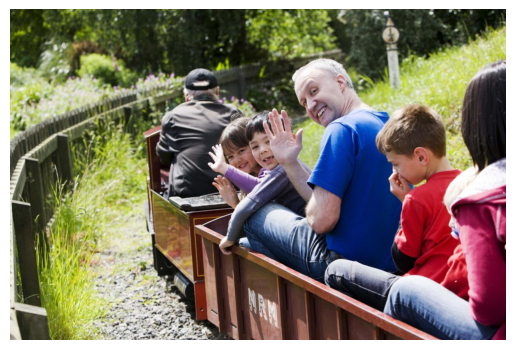

Found 1 face(s)

Face 1:


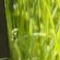

Face 1 top emotions:
  fear: 0.4331
  surprise: 0.3251
  sad: 0.0714

Face detection completed successfully!


In [5]:
# Use OpenCV's Haar Cascade face detector as a more reliable alternative
from IPython.display import display
import random
import matplotlib.pyplot as plt

threshold = 0

# Pick a random image from the findingemo dataset
findingemo_dir = os.path.join(script_dir, '../data/findingemo/Run_2')
scene_dirs = [d for d in os.listdir(findingemo_dir) if os.path.isdir(os.path.join(findingemo_dir, d))]
random_scene = random.choice(scene_dirs)
scene_path = os.path.join(findingemo_dir, random_scene)
img_files = [f for f in os.listdir(scene_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
test_img_path = os.path.join(scene_path, random.choice(img_files))

test_img = cv2.imread(test_img_path)

print(f"Processing image: {test_img_path}")
# Display the original image
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Use OpenCV's built-in Haar Cascade face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Convert to grayscale for face detection
gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

if len(faces) == 0:
    print("No faces detected in the image.")
else:
    print(f"Found {len(faces)} face(s)")
    
    for i, (x, y, w, h) in enumerate(faces):
        # Extract face region
        face_crop = test_img[y:y+h, x:x+w]
        
        # feed the cropped face to the emotion model
        face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
        face_pil = Image.fromarray(face_rgb)
        
        face_input = emotion_processor(images=face_pil, return_tensors="pt")
        with torch.no_grad():
            face_emotion_probs = emotion_model(face_input['pixel_values'])
            if torch.max(face_emotion_probs) < threshold:
                continue
            topk_face_emotions = torch.topk(face_emotion_probs, k=3).indices.squeeze().tolist()

            print(f"\nFace {i+1}:")
            display(face_pil)  # Display the cropped face

            print(f"Face {i+1} top emotions:")
            for idx in topk_face_emotions:
                print(f"  {emotions[idx]}: {face_emotion_probs[0, idx].item():.4f}")

print("\nFace detection completed successfully!")

The dataset also contains valence and arousal. Valence indicates how positive or negative an emotion is, while arousal measures the intensity of the emotion. For example, 'happy' has high valence and high arousal, while 'sad' has low valence and low arousal. This additional information can be useful for more nuanced emotion recognition tasks.

In [6]:
# Create a dataframe for the FindingEmo dataset
import os
import pandas as pd
import random
from io import StringIO
import matplotlib.pyplot as plt
script_dir = os.getcwd()
labels_dir = os.path.join(script_dir, "../data/findingemo/labels")
csv_path = os.path.join(labels_dir, "annotations.csv")
df_findingEmo = pd.read_csv(csv_path)

# delete the columns [index, tags, age, dec_factors, ambiguity, datetime]
df_findingEmo = df_findingEmo.drop(["index", "user", "tags", "age", "dec_factors", "ambiguity", "datetime"], axis=1)

In [7]:
df_findingEmo.head()

,image_path,valence,arousal,emotion
0,/Run_2/Loving toddlers sports/haiti-kids.jpg,0,2,Trust
1,/Run_2/Frustrated forty-something office/team-...,0,2,Interest
2,/Run_1/Violent youth festival/1042373588.jpg,2,2,Interest
3,/Run_2/Remorseful toddlers court of law/dcfs-c...,1,2,Interest
4,/Run_2/Shame elderly sports/3364887-46.jpg,0,3,Apprehension


In [8]:
len(df_findingEmo)

# train_test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_findingEmo, test_size=0.2, random_state=42)

# reset indexes
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [9]:
len(train_df)

20695

In [10]:
len(test_df)

5174

In [11]:
test_df.head()

,image_path,valence,arousal,emotion
0,/Run_2/Sweet toddlers theater/p1222836177-5.jpg,3,5,Joy
1,/Run_2/Anxious children ceremony/black-father-...,2,3,Acceptance
2,/Run_2/Aggressive midlife war/Ein-Becken-volle...,0,1,Anticipation
3,/Run_2/Scared thirty-something grocery store/1...,0,2,Trust
4,/Run_2/Shocked teenagers bathroom/Bathing-At-A...,-1,1,Apprehension
